<center><span style="font-size:36px;">  🏈Expected Tackle Success Rate (ETSR) and Tackle Index🏈</span> </center>

***

### <font color='289C4E'  align>Table of contents<font><a class='anchor' id='top'></a>
- [Introduction](#1)
- [Data Summary](#2)
- [The ETSR Model](#3)
- [Applying ETSR to Player Data](#4)
- [How is this useful and innovative?](#5)


***

# Introduction <a class="anchor"  id="1"></a>

## Tackling Statistics
 Currently, the main metrics that are used to evaluate players and their ability to tackle are composed of raw counts and percentages. We can look at how many solo tackles, assists, and sacks that a player has and we can look at the percentage of tackle attempts they made that were successful. However, we believe that there is a bigger question that needs to be answered...*what makes a good tackle?*

#### By "good", we mean, what differentiates a successful tackle attempt from a missed tackle. 

### Project Goal:
To analyze historical tracking data and extract meaningful features to predict when a tackle attempt will be successful. We will then apply the model to players and determine their "Expected Tackle Success Rate (ETSR)", which we define as "the probability that a player will make a successful tackle when they attempt to tackle, based on their previous behavior."

We also introduce the "Tackle Index", which allows us to rank players based on their current track record related to tackling in addition to their ETSR. This accounts for consistent performance and number of games played.

***

# Data Summary <a class="anchor"  id="2"></a>
The data used for this analysis includes 2022 player tracking data, game data, play data, tackle data, and player statistics. To start, we combined this data to create a comprehensive table that could be used to look at every tackle attempt in the tracking data, tied to the ball carrier at the time and the tackler.


In order to look at what distinguishes a successful tackle from a missed tackle, we specifically excluded assists for the current model. Therefore, we looked at **9884** successful tackles and **2090** missed tackles. 

###  $\frac {9884}{11974}$ = 82.5%

#  The ETSR Model <a class="anchor"  id="3"></a>

Our model of Expected Tackle Success Rate (ETSR) blends the predictions from two classification models: **LGBMClassifier** and **RandomForestClassifier**.
The two models take the following features into account when assessing whether a tackle attempt will be successful:

- The orientation of the tackler
- The direction of the tackler
- The tackler's acceleration
- The ball carrier's speed
- The distance traveled by the ball carrier
- The speed of the tackler before the attempt
- The speed of the ball carrier before the attempt

By blending combinations of these features (i.e. the average speed of the ball carrier and the maximum speed of the tackler before the tackle attempt), the ETSR model predicts the tackle attempts success with **84% accuracy**.

The other metrics we used to assess the model's performance include F1 score, precision, recall, and Cohen's Kappa. (See appendix with resources on classification model metrics).


#  Applying ETSR to Player Data <a class="anchor"  id="4"></a>

We propose that coaches utilize the ETSR model for their players that need to be tracked for tackling ability. The ETSR score ranges from 0 to 1, with 1 being the highest expected success rate. However, this metric can be biased towards players with little data because if they only had one tackle attempt and it was successful, their score will be very close to 1. Therefore, we developed a **Tackle Index**  which factors in how many attempts a player actually made (proxy for their snap count).

## Tackle Index Calculation
The tackle index is relative to other players. It can be negative, zero , or positive depending on the previous tackles and missed tackles that the player has made. On the other hand, RTA always ranges from 0 to 1.

#### ${ETSR \times (Tackle Count + (.5 \times Assist Count)} -{[{(1-ETSR) \times Missed Tackle Count}+1]} $


In [2]:
import warnings
#!pip install eli5
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np

import pandas as pd
import numpy as np
df_games=pd.read_csv('/kaggle/input/nfl-big-data-bowl-2024/games.csv')
df_players=pd.read_csv('/kaggle/input/nfl-big-data-bowl-2024/players.csv')
df_plays=pd.read_csv('/kaggle/input/nfl-big-data-bowl-2024/plays.csv')
df_tackles=pd.read_csv('/kaggle/input/nfl-big-data-bowl-2024/tackles.csv')
files=[]
for i in range(1,10):
    file='/kaggle/input/nfl-big-data-bowl-2024/tracking_week_'+str(i)+'.csv'
    files.append(pd.read_csv(file))
    df_tracking=pd.concat(files) 



In [3]:
#change all plays to same direction
def reverse_deg(deg):
    if deg < 180:
        return deg + 180
    if deg >= 180:
        return deg - 180


In [4]:
df_tracking["o_standard"]=np.where(df_tracking["playDirection"] == "left", df_tracking["o"].apply(reverse_deg), df_tracking["o"])
        
df_tracking["dir_standard"] = np.where(df_tracking["playDirection"] == "left", df_tracking["dir"].apply(reverse_deg), df_tracking["dir"])
        
df_tracking["x_standard"] = np.where(df_tracking["playDirection"] == "left", df_tracking["x"].apply(lambda x: 120 - x), df_tracking["x"])
        
df_tracking["y_standard"] =np.where(df_tracking["playDirection"] == "left",  df_tracking["y"].apply(lambda y: 160/3 - y), df_tracking["y"])
    

In [5]:
def create_gameplayid(df):
    df['gameplayid']=df['gameId'].astype(str)+df['playId'].astype(str)
    return df

def create_index(df):
    df['index']=df['nflId'].astype(str)+df['gameplayid']
    return df
df_tracking=create_index(create_gameplayid(df_tracking))

df_plays=create_gameplayid(df_plays)
df_tackles=create_index(create_gameplayid(df_tackles))



In [6]:
print('Distinct plays in tracking data: ', df_tracking['gameplayid'].nunique())
print('Distinct plays in play data: ', df_plays['gameplayid'].nunique())
print('Distinct plays in tackles data: ', df_tackles['gameplayid'].nunique())

Distinct plays in tracking data:  12486
Distinct plays in play data:  12486
Distinct plays in tackles data:  12025


In [7]:
def merge_clean_data(df_tracking, df_plays, df_tackles):
    df_tracking_plays_final=pd.merge(pd.merge(df_tracking, df_plays, left_on=['gameplayid', 'gameId', 'playId'], right_on=['gameplayid', 'gameId', 'playId'], how='inner'), df_tackles, left_on=['gameplayid', 'gameId', 'playId', 'nflId'], right_on=['gameplayid', 'gameId', 'playId', 'nflId'], how='inner' )
    df_tracking_plays_final['event']=np.where(df_tracking_plays_final['tackle']==1, 'tackle', np.where(df_tracking_plays_final['pff_missedTackle']==1, 'missed_tackle', (np.where(df_tracking_plays_final['assist']==1, 'assist', 'Other')) ))
    df_tackles_final=pd.merge(df_tracking_plays_final, df_tackles, left_on=['gameplayid','gameId', 'playId', 'nflId', 'tackle', 'assist', 'pff_missedTackle'], right_on=['gameplayid','gameId', 'playId', 'nflId', 'tackle', 'assist', 'pff_missedTackle'], how='inner', suffixes=['_1', '_2'])
    df_tackles_final=df_tackles_final[( (df_tackles_final['tackle']+df_tackles_final['assist']+df_tackles_final['pff_missedTackle']>=1)&(df_tackles_final['gameplayid'].isna()==False))]
    df_tackles_final['index']=df_tackles_final['nflId'].astype(str)+df_tackles_final['gameplayid'].astype(str)
    return df_tackles_final
df_tackles_final=merge_clean_data(df_tracking, df_plays, df_tackles)

In [8]:

print('Distinct plays in  final data: ', df_tackles_final['gameplayid'].nunique())
print('Distinct frames in  final data: ', df_tackles_final['index'].nunique())

Distinct plays in  final data:  12022
Distinct frames in  final data:  17420


In [9]:
def ballcarrier_df(df_players):
    df_ballcarrier_players=df_players.copy()
    df_ballcarrier_players.columns=['nflId_ballcarrier', 'ballCarrierHeight', 'ballCarrierWeight', 'ballcarrierDOB', 'ballcarrierCollege', 'ballcarrierPosition', 'ballCarrierDisplayName']
    
    df_tracking_ballcarrier=df_tracking[['gameplayid', 'frameId','nflId', 'x', 'y', 's', 'a', 'dis',
       'o', 'dir', 'event', 'o_standard', 'dir_standard', 'x_standard',
       'y_standard']]
    df_ballcarrier=pd.merge(df_tracking_ballcarrier, df_ballcarrier_players, left_on='nflId', right_on='nflId_ballcarrier')
    df_ballcarrier=df_ballcarrier[['gameplayid', 'frameId',  'x', 'y', 's', 'a', 'dis', 'o',
       'dir', 'event', 'o_standard', 'dir_standard', 'x_standard',
       'y_standard', 'nflId_ballcarrier', 'ballCarrierHeight',
       'ballCarrierWeight', 'ballcarrierDOB', 'ballcarrierCollege',
       'ballcarrierPosition', 'ballCarrierDisplayName']]
    df_ballcarrier.columns=['gameplayid', 'frameId',  'x_ballcarrier', 'y_ballcarrier', 's_ballcarrier',
                        'a_ballcarrier', 'dis_ballcarrier', 'o_ballcarrier',
       'dir_ball_carrier', 'event_ballcarrier', 'o_standard_ballcarrier', 'dir_standard_ballcarrier', 'x_standard_ballcarrier',
       'y_standard_ballcarrier','nflId_ballcarrier', 'ballCarrierHeight',
       'ballCarrierWeight', 'ballcarrierDOB', 'ballcarrierCollege',
       'ballcarrierPosition', 'ballCarrierDisplayName']
    return df_ballcarrier
    
df_ballcarrier=ballcarrier_df(df_players)


In [10]:
def full_merge(df_tackles_final):
    df_players_tackler=df_players.copy()
    df_players_tackler.columns=['nflId_tackler', 'tacklerHeight', 'tacklerWeight', 'tacklerDOB', 'tacklerCollege', 'tacklerPosition', 'tacklerDisplayName']
    df_tackles_final=pd.merge(df_tackles_final, df_players_tackler, left_on='nflId', right_on='nflId_tackler')
    df_full=pd.merge(df_tackles_final, df_ballcarrier, left_on=['gameplayid','ballCarrierDisplayName','frameId'], right_on=['gameplayid', 'ballCarrierDisplayName','frameId'])
    df_full.rename(columns={'nflId':'nflId_tackler', 'x':'x_tackler','y': 'y_tackler', 's':'s_tackler', 'a':'a_tackler', 'dis':'dis_tackler',
       'o':'o_tackler', 'dir':'dir_tackler', 'event':'event_tackler', 'o_standard':'o_standard_tackler',
       'dir_standard':'dir_standard_tackler', 'x_standard':'x_standard_tackler', 'y_standard':'y_standard_tackler'}, inplace=True)
    return df_full
df_full=full_merge(df_tackles_final)

## Key Metrics from Physics
We decided to borrow a few concepts from basic physics to calculate additional metrics for the players (tackler and ball carrier). 
 - Force = Mass x Acceleration
 - Momentum = Mass x Speed
 - Relative velocity
 
 # Relative Velocity and the Coefficient of Restitution: 
- In physics, there are two types of collisions: elastic and inelastic. An elastic collision results in objects moving apart at the same rate at which they collided. On the other hand, an inelastic collision results in objects staying stuck together. According to [The University of Arkansas ](https://phys.libretexts.org/Courses/Merrimack_College/Conservation_Laws_Newton's_Laws_and_Kinematics_version_2.0/08%3A_C8_Conservation_of_Energy-_Kinetic_and_Gravitational/8.05%3A_Relative_Velocity_and_the_Coefficient_of_Restitution) you can quantify how elastic a collision is with the coefficient of restitution (COR). Typically football tackles are classified as inelastic collisions, but we'd like to use the COR to quantify how inelastic a tackle is.

We are suggesting an adjusted COR which adds 1 to the numerator and denominator to account for division by 0.
 

## COR= 
## $\frac{(v_{2f} - v_{1f})+1}{(v_{2i} - v_{1i})+1}$

In [11]:
def create_force_features(df_full):
    df_full['force_ballcarrier']=df_full['ballCarrierWeight']*df_full['a_ballcarrier']
    df_full['force_tackler']=df_full['tacklerWeight']*df_full['a_tackler']
    df_full['momentum_ballcarrier']=df_full['ballCarrierWeight']*df_full['s_ballcarrier']
    df_full['momentum_tackler']=df_full['tacklerWeight']*df_full['s_tackler']
    #calculate distance between player tackling and player being tackled
    df_full['dis_ballcarrier_tackler']=np.sqrt(((df_full['x_standard_ballcarrier'] -df_full['x_standard_tackler'])**2)+((df_full['y_standard_ballcarrier'] -df_full['y_standard_tackler'])**2))
    return df_full
df_full=create_force_features(df_full)


In [12]:
import time

def minutes_to_seconds(minutes):
  return minutes * 60

def seconds_to_minutes(seconds):
  return seconds // 60
def convert_minutes_to_seconds(hours_minutes_and_seconds):
  hours, minutes, seconds = hours_minutes_and_seconds.split(':')
  return minutes_to_seconds(int(minutes)) + seconds_to_minutes(float(seconds))




In [13]:
import datetime 
from datetime import datetime

df_full['time']=df_full['time'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S.%f' ))
df_full['time_adj']=df_full['time'].apply(lambda x: x.time())
df_full['time_seconds']=df_full['time_adj'].apply(lambda x: convert_minutes_to_seconds(str(x)))


In [14]:

df_full['time_elapsed']=df_full.groupby(['gameplayid', 'frameId'])['time_seconds'].diff()
df_full['nflId_tackler']=df_full['nflId_tackler'].astype(str)
df_full['nflId_ballcarrier']=df_full['nflId_ballcarrier'].astype(str)


In [15]:
df_full.sort_values(by=['gameplayid', 'frameId'], inplace=True)


In [16]:

df_full['relative_direction']=df_full['dir_standard_tackler']-df_full['dir_standard_ballcarrier']
df_full['relative_o']=df_full['o_standard_tackler']-df_full['o_standard_ballcarrier']
df_full['playNullifiedByPenalty'].replace({'Y':1, 'N':0}, inplace=True)

In [17]:
df_groupplay=df_full.groupby(by=['gameplayid', 'displayName'])['dis_ballcarrier_tackler'].min().reset_index()
df_groupplay['tackleframe']=1
df_full=pd.merge(df_groupplay, df_full, left_on=['gameplayid', 'displayName', 'dis_ballcarrier_tackler'], right_on=['gameplayid','displayName', 'dis_ballcarrier_tackler'], how='right')
df_full['tackle_frame_final']=np.where((df_full['tackleframe']==1), 1, 0)
df_full['prior_speed_tackler']=df_full.groupby(['gameplayid', 'displayName'])['s_tackler'].shift(1)
df_full['next_speed_tackler']=df_full.groupby(['gameplayid', 'displayName'])['s_tackler'].shift(-1)
df_full['prior_speed_ballcarrier']=df_full.groupby(['gameplayid', 'displayName'])['s_ballcarrier'].shift(1)
df_full['next_speed_ballcarrier']=df_full.groupby(['gameplayid', 'displayName'])['s_ballcarrier'].shift(-1)


In [18]:
def group_by_play(df_full):
    df_full_grouped=df_full.groupby(by=['gameplayid',  'displayName']).agg({'playNullifiedByPenalty':'max', 'relative_o':'mean', 'relative_direction':'mean', 'time':['min', 'max'], 'time_seconds':['min', 'max'],'offenseFormation':pd.Series.mode,'tacklerPosition': pd.Series.mode, 'ballcarrierPosition':pd.Series.mode,'offenseFormation':'first',  'x_tackler':['min', 'max','mean'], 'y_tackler':['min', 'max','mean'],
                                  's_tackler':['first', 'last','min', 'max','mean'], 'a_tackler':['min', 'max','mean'], 'dis_tackler':['min', 'max','mean'],
                                  'o_tackler':['min', 'max','mean'], 'dir_tackler':['min', 'max','mean'], 'o_standard_tackler':['min', 'max','mean'],
                                  'dir_standard_tackler':['min', 'max','mean'], 'x_standard_tackler':['min', 'max','mean'], 'y_standard_tackler':['min', 'max','mean'],
                                  'quarter':['min', 'max','mean'], 'down':['min', 'max','mean'], 'yardsToGo':['min', 'max','mean'],
                                  'gameClock':['min', 'max'], 'preSnapHomeScore':['min', 'max','mean'], 'preSnapVisitorScore':['min', 'max','mean'],
                                  'passLength':['min', 'max','mean'], 'absoluteYardlineNumber':['min', 'max','mean'], 'defendersInTheBox': ['min', 'max','mean'],
                                  'expectedPoints':['min', 'max','mean'], 'tackle':'max', 'assist':'max',  'pff_missedTackle':'max', 'tacklerWeight': 'mean',
                                  'x_ballcarrier': ['min', 'max','mean'], 'y_ballcarrier':['min', 'max','mean'], 's_ballcarrier':['first', 'last','min', 'max','mean'],
                                  'a_ballcarrier':['min', 'max','mean'], 'dis_ballcarrier': ['min', 'max','mean'], 'o_ballcarrier':['min', 'max','mean'],
                                  'o_standard_ballcarrier':['min', 'max','mean'],'dir_standard_ballcarrier':['min', 'max','mean'],
                                  'x_standard_ballcarrier':['min', 'max','mean'], 'y_standard_ballcarrier':['min', 'max','mean'], 'ballCarrierWeight':'mean', 'force_ballcarrier':['min', 'max','mean'],
                                  'force_tackler':['min', 'max','mean']}).reset_index()
    df_full_grouped.columns =df_full_grouped.columns.map('|'.join).str.strip('|')
    return df_full_grouped
df_full_grouped=group_by_play(df_full)


## Summary Statistics

In [19]:
print('Total plays: ', df_full_grouped['gameplayid'].nunique())
print('Total plays not nullified by penalty: ', df_full_grouped[df_full_grouped['playNullifiedByPenalty|max']==0]['gameplayid'].nunique())
print('Total row count: ', len(df_full_grouped[df_full_grouped['playNullifiedByPenalty|max']==0]))
print('Total missed tackles: ', len(df_full_grouped[(df_full_grouped['pff_missedTackle|max']==1)]['gameplayid']))
print('Total assists: ', len(df_full_grouped[((df_full_grouped['assist|max']==1)&(df_full_grouped['pff_missedTackle|max']==0))]['gameplayid']))
print('Total tackles: ', len(df_full_grouped[((df_full_grouped['tackle|max']==1)&(df_full_grouped['assist|max']==0)&(df_full_grouped['pff_missedTackle|max']==0))]['gameplayid']))

Total plays:  12022
Total plays not nullified by penalty:  11700
Total row count:  16988
Total missed tackles:  2090
Total assists:  5446
Total tackles:  9884


In [20]:
##remove plays nullified by penalty 
df_full_grouped=df_full_grouped[df_full_grouped['playNullifiedByPenalty|max']==0]

In [21]:
df_speed_subset=df_full[df_full['tackle_frame_final']==1][['gameplayid', 'displayName', 's_tackler', 'prior_speed_tackler', 'next_speed_tackler', 's_ballcarrier', 'prior_speed_ballcarrier', 'next_speed_ballcarrier']]

In [22]:
df_speed_subset.fillna(0, inplace=True)

In [23]:
df_playdescription = df_plays[['gameId', 'playId', 'playDescription', 'gameClock']].sort_values(by=['gameId',  'gameClock']).set_index('gameId')
df_gamedescription=df_playdescription.groupby(['gameId'])[['playDescription']].transform(lambda x: ','.join(x)).reset_index().drop_duplicates()
df_gamedescription.rename(columns={'playDescription':'gameDescription'}, inplace=True)

In [24]:
df_gamedescription.head()

gameId                                    gameDescription
0    2022090800  (:17) (No Huddle, Shotgun) M.Stafford pass sho...
91   2022091100  (:06) (Shotgun) M.Mariota pass short left to C...
189  2022091101  (:10) (Shotgun) C.McCaffrey up the middle to C...
276  2022091102  (:10) (Shotgun) T.Lance pass short middle to T...
368  2022091103  (:01) (No Huddle) J.Mixon right guard to PIT 4...

In [25]:
def create_position_variables(df_full_grouped):

    ballcarrier_position=pd.get_dummies(df_full_grouped[['gameplayid',  'displayName', 'ballcarrierPosition|mode']], columns=['ballcarrierPosition|mode'],drop_first=True).reset_index(drop=True)
    ballcarrier_position.columns=['gameplayid', 'displayName', 'QB_ballcarrier', 'RB_ballcarrier', 'TE_ballcarrier', 'WR_ballcarrier']
    tackler_position=pd.get_dummies(df_full_grouped[['gameplayid','displayName', 'tacklerPosition|mode']], columns=['tacklerPosition|mode'],drop_first=True).reset_index(drop=True)
    tackler_position.columns=['gameplayid', 'displayName', 'tacklerPosition|mode_DB', 'tacklerPosition|mode_DE',
       'tacklerPosition|mode_DT', 'tacklerPosition|mode_FS',
       'tacklerPosition|mode_ILB', 'tacklerPosition|mode_MLB',
       'tacklerPosition|mode_NT', 'tacklerPosition|mode_OLB',
       'tacklerPosition|mode_SS']
    offense_formation=pd.get_dummies(df_full_grouped[['gameplayid', 'displayName','offenseFormation|first']], columns=['offenseFormation|first'], drop_first=True).reset_index(drop=True)
    df_merge=pd.merge(df_full_grouped,ballcarrier_position, on=['gameplayid', 'displayName'] )
    df_merge=pd.merge(df_merge,tackler_position, on=['gameplayid', 'displayName'])
    df_merge=pd.merge(df_merge, offense_formation, on=['gameplayid', 'displayName'])
    
    
    return df_merge
df_full_grouped=create_position_variables(df_full_grouped)

In [26]:
#create final target variable
df_full_grouped['tackle_assist_success']=np.where(((df_full_grouped['tackle|max']+df_full_grouped['assist|max']>=1)& (df_full_grouped['pff_missedTackle|max']==0)), 1, 0)
df_full_grouped['tackle_success']=np.where((((df_full_grouped['tackle|max']>0) & (df_full_grouped['assist|max']==0))& (df_full_grouped['pff_missedTackle|max']==0)), 1, 0)


In [27]:
df_final=df_full_grouped[df_full_grouped['tackle|max']+df_full_grouped['assist|max']+df_full_grouped['pff_missedTackle|max']>=1]


In [28]:
df_final['event']=np.where(((df_final['tackle_assist_success']==1)& (df_final['assist|max']==0)), 1, np.where((df_final['tackle_assist_success']==1)& (df_final['assist|max']==1), 2, 0))

In [29]:
df_final=pd.merge(df_final, df_speed_subset, left_on=['gameplayid', 'displayName'], right_on=['gameplayid', 'displayName'], how='left')

## Creating new features
We wanted to calculate the range for a few values, including speed, acceleration, orientation, x, and y. 

In [30]:
def create_diff_range(df_final):
    df_final['difference_speed']=df_final['s_tackler|max']-df_final['s_ballcarrier|max']
    df_final['difference_a']=df_final['a_tackler|max']-df_final['a_ballcarrier|max']
    df_final['difference_orientation']=df_final['o_standard_tackler|max']-df_final['o_standard_ballcarrier|max']
    df_final['tackler_x_range']=df_final['x_standard_tackler|max']-df_final['x_standard_tackler|min']
    df_final['tackler_y_range']=df_final['y_standard_tackler|max']-df_final['y_standard_tackler|min']
    df_final['tackler_s_range']=df_final['s_tackler|max']-df_final['s_tackler|min']
    df_final['tackler_a_range']=df_final['a_tackler|max']-df_final['a_tackler|min']
    df_final['o_range_tackler']=df_final['o_standard_tackler|max']-df_final['o_standard_tackler|min']
    df_final['dir_range_tackler']=df_final['dir_standard_tackler|max']-df_final['dir_standard_tackler|min']
    df_final['ballcarrier_x_range']=df_final['x_standard_ballcarrier|max']-df_final['x_standard_ballcarrier|min']
    df_final['ballcarrier_y_range']=df_final['y_standard_ballcarrier|max']-df_final['y_standard_ballcarrier|min']
    df_final['ballcarrier_s_range']=df_final['s_ballcarrier|max']-df_final['s_ballcarrier|min']
    df_final['ballcarrier_a_range']=df_final['a_ballcarrier|max']-df_final['a_ballcarrier|min']
    df_final['o_range_ballcarrier']=df_final['o_standard_ballcarrier|max']-df_final['o_standard_ballcarrier|min']
    df_final['dir_range_ballcarrier']=df_final['dir_standard_ballcarrier|max']-df_final['dir_standard_ballcarrier|min']

    return df_final
df_final=create_diff_range(df_final)

In [31]:
df_final['next_speed_diff']= (df_final['next_speed_tackler']-df_final['next_speed_ballcarrier'])
df_final['prior_speed_diff']=(df_final['prior_speed_tackler']-df_final['prior_speed_ballcarrier'])
df_final['COR']=np.where(df_final['tackle_assist_success']==1, (df_final['next_speed_diff']+1).astype(float)/(df_final['prior_speed_diff']+1).astype(float),0 )


In [32]:

df_final['COR'].replace([float('inf'), float('-inf')], 0, inplace=True)
df_successful_tackles=df_final[df_final['tackle_assist_success']==1]


In [33]:
df_final_subset= df_final.select_dtypes(include='number')
from scipy.stats import pointbiserialr
positive_variables=[]
negative_variables=[]
for col in df_final_subset.columns:
    if df_final_subset[col].isna().sum()==0:
        corr, p =pointbiserialr(df_final_subset[col], df_final_subset['tackle_assist_success'])
        if corr >=.08 and p<.05:
            positive_variables.append(col)
        if corr <=-.08  and p<.05:
            negative_variables.append(col)
        

print(positive_variables)
print(negative_variables)

['relative_o|mean', 's_tackler|min', 'a_tackler|min', 'dis_tackler|min', 'o_tackler|min', 'dir_tackler|min', 'o_standard_tackler|min', 'o_standard_tackler|mean', 'dir_standard_tackler|min', 'tackle|max', 'assist|max', 'o_standard_ballcarrier|mean', 'force_tackler|min', 'tackle_assist_success', 'tackle_success', 'event', 'next_speed_diff']
['a_tackler|max', 'o_tackler|max', 'pff_missedTackle|max', 's_ballcarrier|last', 's_ballcarrier|max', 's_ballcarrier|mean', 'dis_ballcarrier|max', 'dis_ballcarrier|mean', 'x_standard_ballcarrier|max', 'force_tackler|max', 's_tackler', 'prior_speed_tackler', 'next_speed_tackler', 's_ballcarrier', 'prior_speed_ballcarrier', 'next_speed_ballcarrier', 'tackler_x_range', 'tackler_s_range', 'tackler_a_range', 'o_range_tackler', 'dir_range_tackler', 'ballcarrier_x_range', 'ballcarrier_y_range', 'ballcarrier_s_range']


In [34]:
df_final_subset= df_final.select_dtypes(include='number')
from scipy.stats import pointbiserialr
positive_variables2=[]
negative_variables2=[]
for col in df_final_subset.columns:
    if df_final_subset[col].isna().sum()==0:
        corr, p =pointbiserialr(df_final_subset[col], df_final_subset['pff_missedTackle|max'])
        if corr >=.08 and p<.05:
            positive_variables2.append(col)
        if corr <=-.08  and p<.05:
            negative_variables2.append(col)
        

print(positive_variables2)
print(negative_variables2)

['a_tackler|max', 'o_tackler|max', 'pff_missedTackle|max', 's_ballcarrier|last', 's_ballcarrier|max', 's_ballcarrier|mean', 'dis_ballcarrier|max', 'dis_ballcarrier|mean', 'x_standard_ballcarrier|max', 'force_tackler|max', 's_tackler', 'prior_speed_tackler', 'next_speed_tackler', 's_ballcarrier', 'prior_speed_ballcarrier', 'next_speed_ballcarrier', 'tackler_x_range', 'tackler_s_range', 'tackler_a_range', 'o_range_tackler', 'dir_range_tackler', 'ballcarrier_x_range', 'ballcarrier_y_range', 'ballcarrier_s_range']
['relative_o|mean', 's_tackler|min', 'a_tackler|min', 'dis_tackler|min', 'o_tackler|min', 'dir_tackler|min', 'o_standard_tackler|min', 'o_standard_tackler|mean', 'dir_standard_tackler|min', 'tackle|max', 'assist|max', 'o_standard_ballcarrier|mean', 'force_tackler|min', 'tackle_assist_success', 'tackle_success', 'event', 'next_speed_diff']


In [35]:
df_final.fillna(0, inplace=True)

In [36]:
final_cols=[
 'o_standard_tackler|min',
 'o_standard_tackler|mean',
 'dir_standard_tackler|min',
 'a_tackler|max',
 's_ballcarrier|max',
 's_ballcarrier|mean',
 'dis_ballcarrier|mean',
 'prior_speed_tackler',
 'prior_speed_ballcarrier',
 'tackler_s_range',
 'tackler_a_range',
 'o_range_tackler',
 'dir_range_tackler',
 'ballcarrier_s_range'
]

In [37]:
# Outlier Analysis

iqr_factor = [3]
list1, list2 = [], []

for factor in iqr_factor:
    count = 0
    print(f'Outliers for {factor} IQR :')
    print('-------------------------------------')
    for col in final_cols:
    
        IQR = df_final[col].quantile(0.75) - df_final[col].quantile(0.25)
        lower_lim = df_final[col].quantile(0.25) - factor*IQR
        upper_lim = df_final[col].quantile(0.75) + factor*IQR
    
        cond = df_final[(df_final[col] < lower_lim) | (df_final[col] > upper_lim)].shape[0]
        
        if cond > 0 and factor == 1.5:
            list1.append(df_final[(df_final[col] < lower_lim) | (df_final[col] > upper_lim)].index.tolist())
        elif cond > 0 and factor == 3:
            list2.append(df_final[(df_final[col] < lower_lim) | (df_final[col] > upper_lim)].index.tolist())
        
        if cond > 0: print(f'{col:<30} : ', cond); count += cond
    print(f'\nTOTAL OUTLIERS FOR {factor} IQR : {count}')
    print('')

Outliers for 3 IQR :
-------------------------------------
a_tackler|max                  :  6
tackler_a_range                :  7

TOTAL OUTLIERS FOR 3 IQR : 13



In [38]:
def drop_outliers(df_final, col):
    IQR = df_final[col].quantile(0.75) - df_final[col].quantile(0.25)
    lower_lim = df_final[col].quantile(0.25) - (2*IQR)
    upper_lim = df_final[col].quantile(0.75) + (2*IQR)
    df_final.drop(df_final[df_final[col]>(upper_lim)].index, inplace=True)
    df_final.drop(df_final[df_final[col]<(lower_lim)].index, inplace=True)

for col in final_cols:
    drop_outliers(df_final,col)

<Axes: title={'center': 'Correlation Heatmap of Features'}>

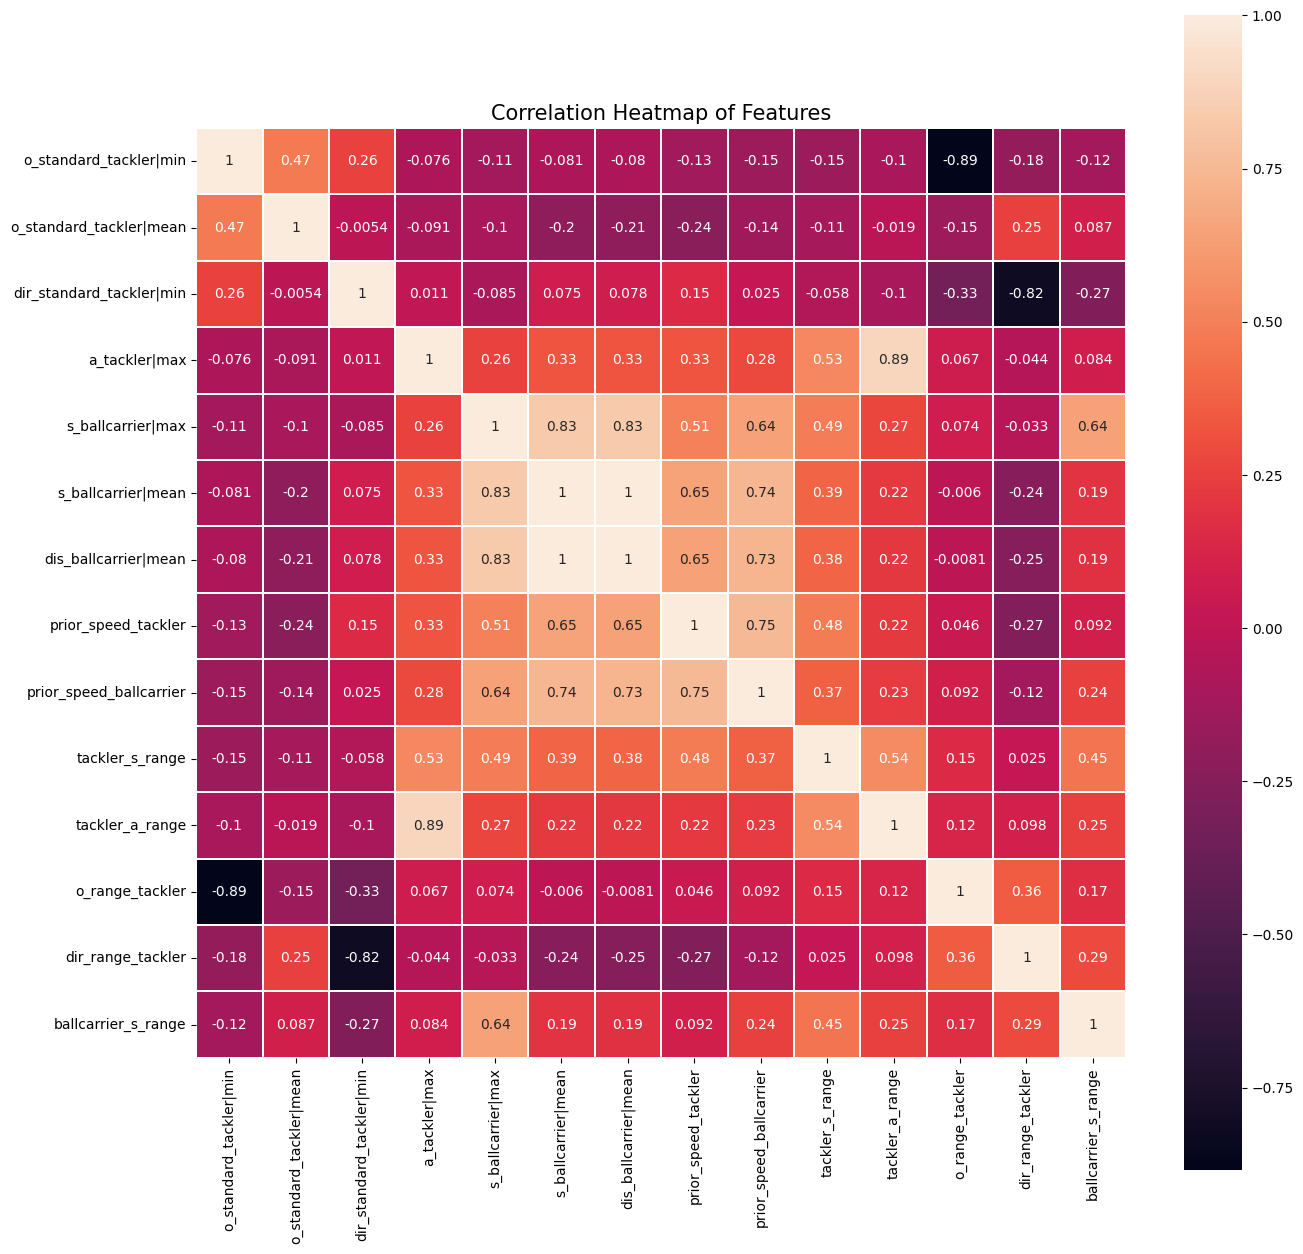

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,15))
plt.title('Correlation Heatmap of Features', size=15)

sns.heatmap(df_final_subset[final_cols].astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, linecolor='white', annot=True)

In [40]:
df_set=df_final[['displayName', 'tackle|max','assist|max','pff_missedTackle|max',
               'o_standard_tackler|min',
 'o_standard_tackler|mean',
 'dir_standard_tackler|min',
 'a_tackler|max',
 's_ballcarrier|max',
 's_ballcarrier|mean',
 'dis_ballcarrier|mean',
 'prior_speed_tackler',
 'prior_speed_ballcarrier',
 'tackler_s_range',
 'tackler_a_range',
 'o_range_tackler',
 'dir_range_tackler',
 'ballcarrier_s_range'
]].groupby(by=['displayName']).mean().reset_index()
df_set

df_set_gameplays=df_final[['displayName', 'gameplayid']].groupby(by='displayName').nunique().reset_index()
df_set_tackleassist=df_final[['displayName', 'tackle_assist_success', 'pff_missedTackle|max', 'assist|max', 'tackle|max']].groupby(by='displayName').sum().reset_index()
df_set['gameplayid|nunique']=df_set_gameplays['gameplayid']
df_set[['tackle_assist_count', 'missedTacklecount', 'assist_count', 'tackle_count']]=df_set_tackleassist[['tackle_assist_success', 'pff_missedTackle|max','assist|max', 'tackle|max']]


In [41]:
# Compare Algorithms
!pip install xgboost
import pandas
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold,StratifiedGroupKFold, train_test_split
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


weak_learner = DecisionTreeClassifier(max_leaf_nodes=8)
df_final2=df_final[df_final['event']!=2]
X=df_final2[final_cols
    
]
X.fillna(0, inplace=True) ##fill in missing pass length to 0
groups=df_final2['displayName']
y=df_final2['event']
"""
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []

models.append(('LDA', LinearDiscriminantAnalysis()))
##models.append(('KNN', KNeighborsClassifier()))
models.append(('LGBM', LGBMClassifier()))
models.append(('XBG', XGBClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('adaboost_clf', AdaBoostClassifier(
    estimator=weak_learner,
    algorithm="SAMME",
    random_state=42,
)))
models.append(('LG', LogisticRegression()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'

for name, model in models:
    kfold = StratifiedKFold(n_splits=5)
    
    cv_results = model_selection.cross_val_score(model, X, y,  cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Comparing Base Models')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
ax.set_ylabel('Accuracy Score')
plt.show()
"""

'\n# prepare configuration for cross validation test harness\nseed = 7\n# prepare models\nmodels = []\n\nmodels.append((\'LDA\', LinearDiscriminantAnalysis()))\n##models.append((\'KNN\', KNeighborsClassifier()))\nmodels.append((\'LGBM\', LGBMClassifier()))\nmodels.append((\'XBG\', XGBClassifier()))\nmodels.append((\'CART\', DecisionTreeClassifier()))\nmodels.append((\'NB\', GaussianNB()))\nmodels.append((\'SVM\', SVC()))\nmodels.append((\'adaboost_clf\', AdaBoostClassifier(\n    estimator=weak_learner,\n    algorithm="SAMME",\n    random_state=42,\n)))\nmodels.append((\'LG\', LogisticRegression()))\n\n# evaluate each model in turn\nresults = []\nnames = []\nscoring = \'accuracy\'\n\nfor name, model in models:\n    kfold = StratifiedKFold(n_splits=5)\n    \n    cv_results = model_selection.cross_val_score(model, X, y,  cv=kfold, scoring=scoring)\n    results.append(cv_results)\n    names.append(name)\n    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())\n    print(msg)\

The boxplot above compares the accuracy of the three models. It is clear that LGBM has the highest accuracy and therefore we will continue to tune this model.

In [42]:
#!pip install optuna
import optuna  # pip install optuna
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import StratifiedKFold
from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X, y, stratify=y)

def objective(trial):
    """
    Objective function to be minimized.
    """
    param = {
        "objective": "binary",
        "metric": "logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "num_class": 1,
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "learning_rate": trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    }
    gbm = LGBMClassifier(**param)
    gbm.fit(X_train, y_train)
    preds = gbm.predict(X_test)
    prob = gbm.predict_proba(X_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy

In [43]:
#sampler = TPESampler(seed=1)
#study = optuna.create_study(study_name="lightgbm", direction="maximize")
#study.optimize(objective, n_trials=100, show_progress_bar=True)


## LGBM best params


In [44]:
#print('Best parameters:', study.best_params)

In [45]:
X_train, X_test, y_train, y_test=train_test_split(X, y, stratify=y)

def objective(trial):
    """
    Objective function to be minimized.
    """
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }
    gbm =XGBClassifier(**param)
    gbm.fit(X_train, y_train)
    preds = gbm.predict(X_test)
    prob = gbm.predict_proba(X_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy

#study = optuna.create_study(study_name="xgb", direction="maximize")
#study.optimize(objective, n_trials=100, show_progress_bar=True)

In [46]:
#print('Best parameters:', study.best_params)

In [47]:
def objective(trial):
    """
    Objective function to be minimized.
    """
    param = {
    'n_estimators': trial.suggest_int("n_estimators", 10, 200, log=True),
    'max_depth' : trial.suggest_int("max_depth", 2, 32),
    'min_samples_split' : trial.suggest_int("min_samples_split", 2, 10),
    'min_samples_leaf' : trial.suggest_int("min_samples_leaf", 1, 10)
    }
    rf =RandomForestClassifier(**param)
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)
    prob = rf.predict_proba(X_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy

#study = optuna.create_study(study_name="rf", direction="maximize")
#study.optimize(objective, n_trials=100, show_progress_bar=True)

In [48]:
#print('Best parameters:', study.best_params)

In [49]:
lgbmparams={'lambda_l1': 4.050150332778803e-08, 'lambda_l2': 0.008396253957140833, 'num_leaves': 249, 'feature_fraction': 0.646934695345336, 'bagging_fraction': 0.45014301555842917, 'bagging_freq': 1, 'min_child_samples': 98, 'learning_rate': 0.07472318306842454, 'class_weight':{0:3, 1:1}}
xgbparams= {'max_depth': 6, 'learning_rate': 0.061078105713091524, 'n_estimators': 188, 'min_child_weight': 6, 'gamma': 3.1911859793846633e-05, 'subsample': 0.6397493674824285, 'colsample_bytree': 0.539143847097296, 'reg_alpha': 5.6540580944227995e-06, 'reg_lambda': 3.13066153115124e-05}
rfparams={'n_estimators': 133, 'max_depth': 31, 'min_samples_split': 5, 'min_samples_leaf': 1}

Accuracy: 0.8240027991602519
F1: 0.45175522731632456
Precision: 0.41200139958012594
Recall: 0.5
Kappa: 0.0
AUC:  0.5


Text(0.5, 1.0, 'Confusion Matrix')

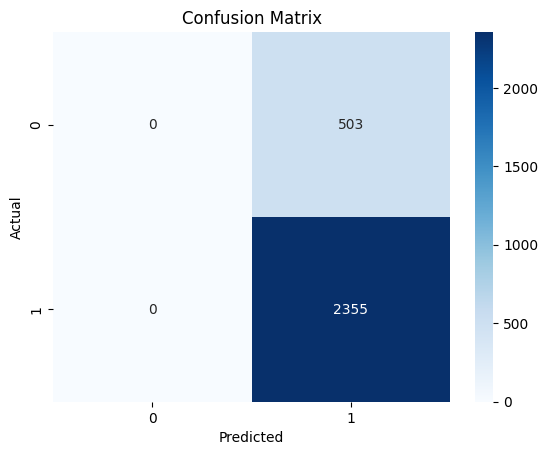

In [50]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_squared_error, f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

from sklearn.metrics import roc_auc_score




dummy_clf = DummyClassifier(strategy="most_frequent")
X=df_final2[final_cols
    
]
X.fillna(0, inplace=True) ##fill in missing pass length to 0
groups=df_final2['displayName']
y=df_final2['event']

X_train, X_test, y_train, y_test = train_test_split(X ,y, stratify=y, test_size=0.25, random_state=0)

dummy_clf.fit(X_train, y_train)



y_pred =  dummy_clf.predict(X_test)
y_proba=dummy_clf.predict_proba(X_test)
matrix = confusion_matrix(y_test, y_pred)
print("Accuracy:", accuracy_score(y_test, y_pred))

print("F1:", f1_score(y_test, y_pred,average='macro'))
print("Precision:", precision_score(y_test, y_pred,average='macro'))
print("Recall:", recall_score(y_test, y_pred,average='macro'))
print("Kappa:", cohen_kappa_score(y_test, y_pred))

print("AUC: ", roc_auc_score(y_test, y_pred))


sns.heatmap(matrix, annot=True,  cmap="Blues", fmt="g")
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')

[LightGBM] [Warning] lambda_l1 is set=4.050150332778803e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.050150332778803e-08
[LightGBM] [Warning] feature_fraction is set=0.646934695345336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.646934695345336
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.008396253957140833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008396253957140833
[LightGBM] [Warning] bagging_fraction is set=0.45014301555842917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45014301555842917
[LightGBM] [Warning] lambda_l1 is set=4.050150332778803e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.050150332778803e-08
[LightGBM] [Warning] feature_fraction is set=0.646934695345336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.646934695345336
[LightGBM] [Warning] ba

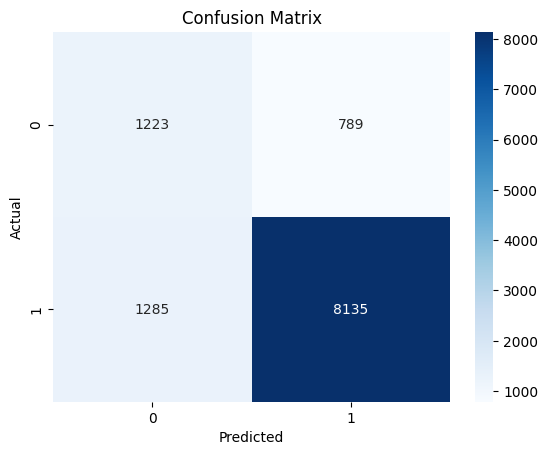

In [51]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score
from typing import Tuple
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.under_sampling import TomekLinks

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import NeighbourhoodCleaningRule

model =LGBMClassifier(**lgbmparams)
X=df_final2[final_cols
    
]
X.fillna(0, inplace=True) ##fill in missing pass length to 0
groups=df_final2['displayName']
y=df_final2['event']
kfold=StratifiedKFold(n_splits=5,  random_state=None, shuffle=True)
def cross_val_predict(model, kfold : KFold, X : np.array, y : np.array) -> Tuple[np.array, np.array]:

    kfold=StratifiedKFold(n_splits=5,  random_state=None, shuffle=True)
    groups=df_final2['displayName']
    
    
    
    no_classes = len(np.unique(y))
    
    actual_classes = np.empty([0], dtype=int)
    predicted_classes = np.empty([0], dtype=int)
    predicted_proba = np.empty([0, no_classes]) 

    for train_ndx, test_ndx in kfold.split(X, y):

        X_train, y_train, X_test, y_test = X[train_ndx], y[train_ndx], X[test_ndx], y[test_ndx]
       
        
        model.fit(
            X_train, y_train
        )


        


      
        actual_classes = np.append(actual_classes, y_test)
        

        predicted_classes = np.append(predicted_classes, model.predict(X_test))

        try:
            predicted_proba = np.append(predicted_proba, model.predict_proba(X_test), axis=0)
        except:
            predicted_proba = np.append(predicted_proba, np.zeros((len(X_test), no_classes), dtype=float), axis=0)

    return actual_classes, predicted_classes, predicted_proba
def plot_confusion_matrix(actual_classes : np.array, predicted_classes : np.array, sorted_labels : list):

    matrix = confusion_matrix(actual_classes, predicted_classes, labels=sorted_labels)
    print("Accuracy:", accuracy_score(actual_classes, predicted_classes))

    print("F1:", f1_score(actual_classes, predicted_classes,average='macro'))
    print("Precision:", precision_score(actual_classes, predicted_classes,average='macro'))
    print("Recall:", recall_score(actual_classes, predicted_classes,average='macro'))
    print("Kappa:" , cohen_kappa_score(actual_classes, predicted_classes))
    print("AUC: ",  roc_auc_score(actual_classes, predicted_classes))
    plt.figure()
    sns.heatmap(matrix, annot=True, xticklabels=sorted_labels, yticklabels=sorted_labels, cmap="Blues", fmt="g")
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')

    plt.show()
    
actual_classes, predicted_classes, _ = cross_val_predict(model, kfold, X.to_numpy(), y.to_numpy())
plot_confusion_matrix(actual_classes, predicted_classes, [0,1])

Accuracy: 0.8558432470258922
F1: 0.6833133470430208
Precision: 0.7786010387939855
Recall: 0.6508452469894012
Kappa: 0.37772375597175833
AUC:  0.6508452469894013


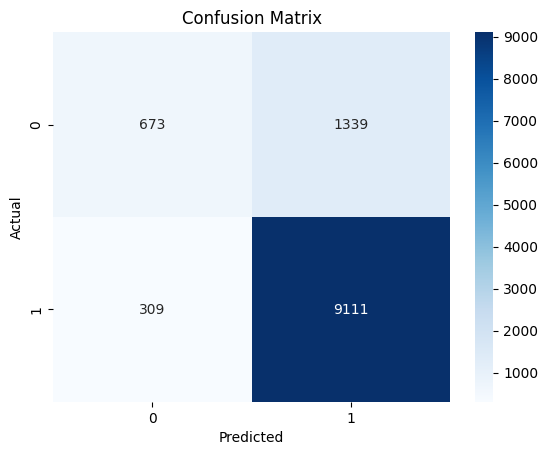

In [52]:
model=XGBClassifier(**xgbparams)
actual_classes, predicted_classes, _ = cross_val_predict(model, kfold, X.to_numpy(), y.to_numpy())
plot_confusion_matrix(actual_classes, predicted_classes, [0,1])

Accuracy: 0.8520818754373688
F1: 0.6527961651004173
Precision: 0.7867721697356819
Recall: 0.6225706271922604
Kappa: 0.32463634529184326
AUC:  0.6225706271922604


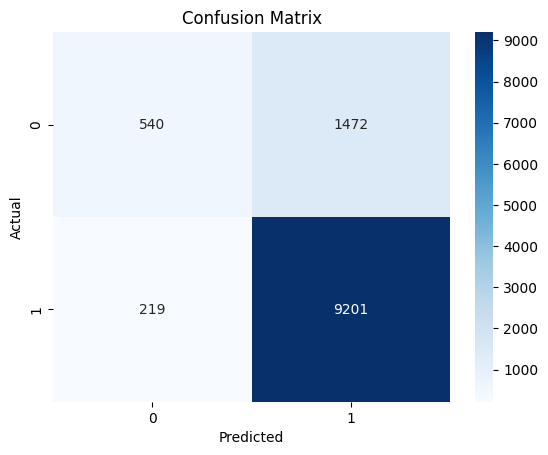

In [53]:
model=RandomForestClassifier(**rfparams)
actual_classes, predicted_classes, _ = cross_val_predict(model, kfold, X.to_numpy(), y.to_numpy())
plot_confusion_matrix(actual_classes, predicted_classes, [0,1])

In [54]:

df_final2=df_final[df_final['event']!=2]
X=df_final2[final_cols
    
]
X.fillna(0, inplace=True) ##fill in missing pass length to 0
groups=df_final2['displayName']
y=df_final2['event']
X_train, X_test, y_train, y_test = train_test_split(X ,y, stratify=y, test_size=0.25, random_state=0)
import shap
# DF, based on which importance is checked


#model1=XGBClassifier(**xgbparams)
#model1.fit(X_train, y_train)
#probs1=model1.predict_proba(X)
model2=LGBMClassifier(**lgbmparams)
model2.fit(X_train, y_train)
probs2=model2.predict_proba(X_test)
model3=RandomForestClassifier(**rfparams)
model3.fit(X_train, y_train)
probs3=model3.predict_proba(X_test)
#df_final['prob_tackle1']=probs1[:, 1]
#df_final['prob_miss1']=probs1[:, 0]





[LightGBM] [Warning] lambda_l1 is set=4.050150332778803e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.050150332778803e-08
[LightGBM] [Warning] feature_fraction is set=0.646934695345336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.646934695345336
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.008396253957140833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008396253957140833
[LightGBM] [Warning] bagging_fraction is set=0.45014301555842917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45014301555842917


In [55]:
import shap


explainer2 = shap.Explainer(model2.predict, X_test)
shap_values2 = explainer2(X_test)




PermutationExplainer explainer: 2859it [10:51,  4.35it/s]                          


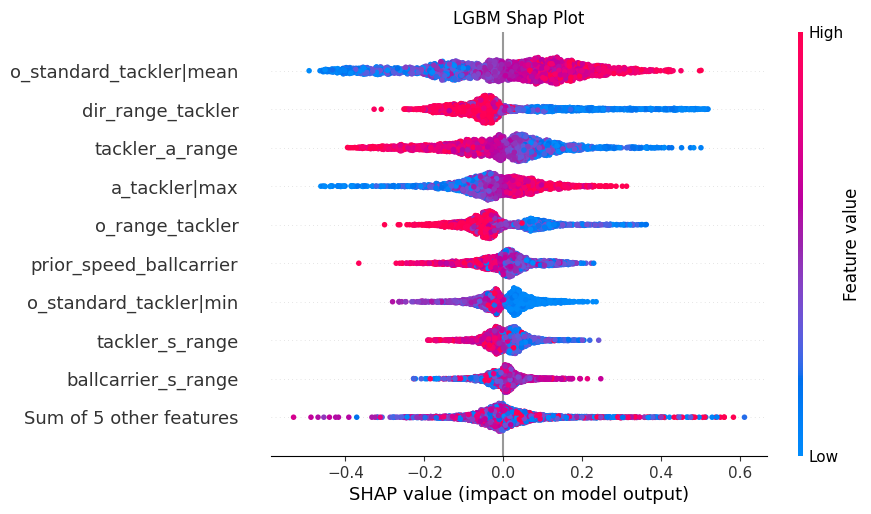

In [56]:
shap.plots.beeswarm(shap_values2, show=False)
plt.title('LGBM Shap Plot')
plt.savefig('LGBMshap.png', bbox_inches='tight')

In [ ]:

explainer3 = shap.Explainer(model3.predict, X_test)
shap_values3 = explainer3(X_test)




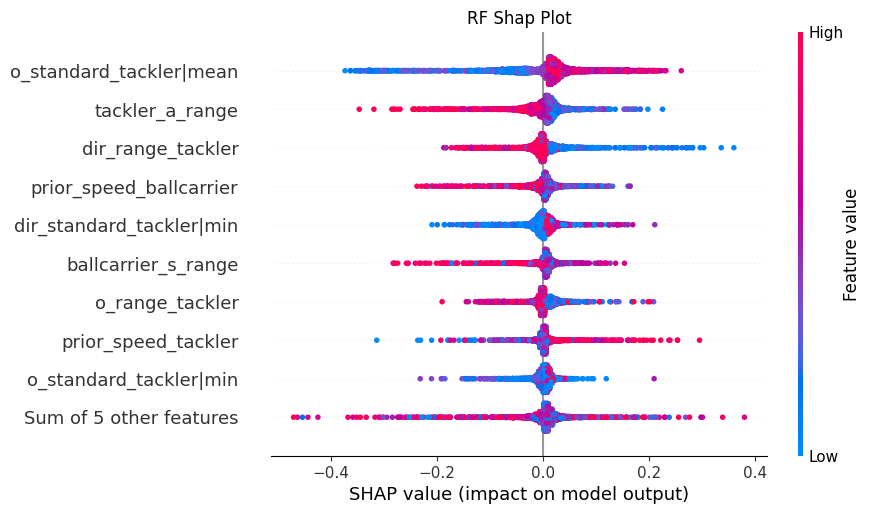

In [59]:

shap.plots.beeswarm(shap_values3, show=False)
plt.title('RF Shap Plot')
plt.savefig('RFshap.png', bbox_inches='tight')

In [60]:
plt.savefig('RFshap.png')

<Figure size 640x480 with 0 Axes>

In [61]:

X_test['prob_tackle2']=probs2[:, 1]
X_test['prob_miss2']=probs2[:, 0]



X_test['prob_tackle3']=probs3[:, 1]
X_test['prob_miss3']=probs3[:, 0]


X_test['prob_tackle']=((X_test['prob_tackle2']*3)+X_test['prob_tackle3'])/4
X_test['prob_miss']=((X_test['prob_miss2']*3)+X_test['prob_miss3'])/4

X_test['prediction']=np.where(X_test['prob_tackle']>.5, 1, 0)

X_test['y_test']=y_test

Accuracy: 0.8428971308607418
F1: 0.7293859104341389
Precision: 0.7292071246510499
Recall: 0.7295652834584847
Kappa: 0.4587719350041459
AUC:  0.7295652834584847


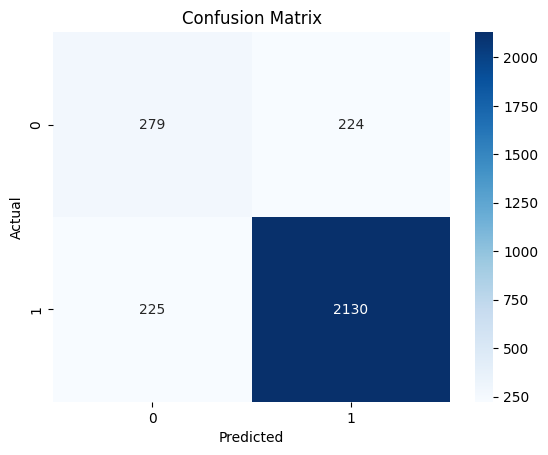

In [62]:
plot_confusion_matrix(X_test['y_test'], X_test['prediction'], [0,1])

In [63]:


gain_importance = model2.feature_importances_

# Display feature importance with feature names
feature_names =  final_cols
 

gain_importance_df = pd.DataFrame({'Feature': feature_names, 'Gain': gain_importance})
gain_importance_df.sort_values(by='Gain', ascending=False).head(10)


Feature  Gain
1   o_standard_tackler|mean   295
10          tackler_a_range   256
8   prior_speed_ballcarrier   245
12        dir_range_tackler   233
0    o_standard_tackler|min   231
13      ballcarrier_s_range   229
7       prior_speed_tackler   223
11          o_range_tackler   213
3             a_tackler|max   201
9           tackler_s_range   200

In [64]:

gain_importance = model3.feature_importances_

# Display feature importance with feature names
feature_names =  final_cols
 

gain_importance_df = pd.DataFrame({'Feature': feature_names, 'Gain': gain_importance})
gain_importance_df.sort_values(by='Gain', ascending=False).head(10)

Feature      Gain
1    o_standard_tackler|mean  0.123220
12         dir_range_tackler  0.091756
11           o_range_tackler  0.078966
8    prior_speed_ballcarrier  0.074637
7        prior_speed_tackler  0.074311
0     o_standard_tackler|min  0.071308
9            tackler_s_range  0.069852
2   dir_standard_tackler|min  0.068433
13       ballcarrier_s_range  0.065548
10           tackler_a_range  0.063755

** Notes ** 
1. Raw tackling ability
2. Defensive scheme - scheme alignment, tackle probability (likely relative to offense alignment)
3. In play tackle likelihood by player 
- Data points to consider for 2 above:
    - offensive first formation
    - offensive formation at time of snap
    - defensive first formation
    - defensive formation at time of snap
- Data points to consider for 1 above:
    - stats by play by player (ex. x-range by player by play by position)
    - position 
    - raw athletic score vs. actual on field production
    - play speed for tackler
    - vision score
    - time to correct movement after ball carrier established
    - angle of approach

In [65]:
X=df_set[final_cols]


probs2=model2.predict_proba(X)
probs3=model3.predict_proba(X)


df_set['prob_tackle2']=probs2[:, 1]
df_set['prob_miss2']=probs2[:, 0]



df_set['prob_tackle3']=probs3[:, 1]
df_set['prob_miss3']=probs3[:, 0]


df_set['ETSR']=((3*df_set['prob_tackle2'])+df_set['prob_tackle3'])/4




In [66]:
df_set['tackle_index']=round((df_set['ETSR']*((df_set['tackle_count']*1)+(df_set['assist_count']*.5)))-((1-df_set['ETSR'])*(df_set['missedTacklecount']+1)), 2)

In [67]:
df_tackles

gameId  playId  nflId  tackle  assist  forcedFumble  \
0      2022090800     101  42816       1       0             0   
1      2022090800     393  46232       1       0             0   
2      2022090800     486  40166       1       0             0   
3      2022090800     646  47939       1       0             0   
4      2022090800     818  40107       1       0             0   
...           ...     ...    ...     ...     ...           ...   
17421  2022091113    2494  43533       0       0             0   
17422  2022092502    3510  42406       0       0             0   
17423  2022091113    3642  43478       0       0             0   
17424  2022091901    3578  42431       0       0             0   
17425  2022091901    3845  46199       0       0             0   

       pff_missedTackle      gameplayid                index  
0                     0   2022090800101   428162022090800101  
1                     0   2022090800393   462322022090800393  
2                     0   2022090800486   401662022090800486  
3                     0   2022090800646   479392022090800646  
4                     0   2022090800818   401072022090800818  
...                 ...             ...                  ...  
17421                 1  20220911132494  4353320220911132494  
17422                 1  20220925023510  4240620220925023510  
17423                 1  20220911133642  4347820220911133642  
17424                 1  20220919013578  4243120220919013578  
17425                 1  20220919013845  4619920220919013845  

[17426 rows x 9 columns]

In [68]:

df_tackler_merge=pd.merge(df_players[['nflId', 'position', 'displayName']], df_set[['displayName', 'tackle_index', 'ETSR']], on='displayName')
df_tackles_grouped=df_tackles[['nflId', 'tackle', 'assist', 'forcedFumble', 'pff_missedTackle']].groupby('nflId').sum() 
df_tackler_merge=pd.merge(df_tackler_merge, df_tackles_grouped, on='nflId')
df_tackler_merge.sort_values(by='tackle_index', ascending=False, inplace=True)
df_tackler_merge.reset_index(inplace=True)
df_tackler_merge[['displayName', 'position', 'tackle_index', 'ETSR', 'tackle', 'assist', 'forcedFumble', 'pff_missedTackle']].sort_values(by='tackle_index', ascending=False).head(10)

displayName position  tackle_index      ETSR  tackle  assist  \
0     Jordyn Brooks      ILB         45.53  0.689391      61      23   
1  Foyesade Oluokun      ILB         42.66  0.642609      59      26   
2       C.J. Mosley      ILB         40.22  0.665161      55      32   
3     Divine Deablo      OLB         38.76  0.730577      39      34   
4       Pete Werner      OLB         38.68  0.701949      51      22   
5     Rashaan Evans      ILB         38.40  0.662826      45      39   
6    Jonathan Owens       FS         38.33  0.759497      45      19   
7     Bobby Okereke      ILB         36.42  0.642194      48      23   
8      Bobby Wagner      ILB         34.96  0.739223      40      23   
9      Mykal Walker      ILB         34.84  0.719960      43      25   

   forcedFumble  pff_missedTackle  
0             1                10  
1             0                11  
2             0                 8  
3             0                 7  
4             2                 8  
5             1                 6  
6             0                 7  
7             1                 4  
8             0                 1  
9             1                 7

In [69]:
df_tackler_merge[['displayName', 'position', 'tackle_index', 'ETSR', 'tackle', 'assist', 'forcedFumble', 'pff_missedTackle']].sort_values(by='ETSR', ascending=False).head(10)

displayName position  tackle_index      ETSR  tackle  assist  \
633   Brandin Echols       CB          1.48  0.993854       2       1   
593     Ambry Thomas       CB          1.98  0.992974       3       0   
679      Arron Mosby      OLB          0.97  0.985454       1       0   
713     Percy Butler       FS          0.48  0.985320       0       1   
594  Zech McPhearson       CB          1.95  0.982634       2       0   
682   Luke Masterson      OLB          0.95  0.976100       0       2   
635   Michael Thomas       SS          1.43  0.971284       1       1   
718       Tony Adams       FS          0.45  0.969885       0       1   
716  Dicaprio Bootle       CB          0.45  0.968558       0       1   
717      Daniel Wise       DE          0.45  0.967161       0       2   

     forcedFumble  pff_missedTackle  
633             0                 0  
593             0                 0  
679             0                 0  
713             0                 0  
594             0                 0  
682             0                 0  
635             0                 0  
718             0                 0  
716             0                 0  
717             0                 0

<center><span style="font-size:36px;">  C.J. Mosley vs. Tony Adams</span> </center>

C.J.  Mosley is a top player from the NY Jets, but we wanted to look at his tackling stats compared to his teammate, Tony Adams. Mosley had **158 combined tackles and assists in 2022 and 131 in 2023**. Based on an analysis of his plays from 2022, his **ETSR is .65**, yet his tackle index is very high, putting him in the **top 10 players**.

On the other hand, Tony Adams has an **extremely high ETSR of .968 based on his 1 successful assist** that was recorded in our 2022 tracking data. His tackle index in 2022 was very low because he didn't play in many games, but based on the actions he took during that play, we expect his tackle success rate to be high, which is supported by his performance in 2023.


 > ## "We have all these guys that play at an All-Pro level, and it makes you want to be better," Adams said. "I am just going out there and trying to be better because of those guys. And one day, I have hopes to play at that level too." 
  [NewYorkJets.com](https://www.newyorkjets.com/news/jets-tony-adams-buffalo-bills-josh-allen)

#### Maybe he can...


<br></br>
 <center><img src="https://static.clubs.nfl.com/image/private/t_editorial_landscape_6_desktop/f_png/jets/h0j0fahb2xtffumugal3.png" alt="CJ Mosley" width="300"/></center>
## <center>C.J. Mosley</center> 

<br></br>

|SEASON |TEAM   |  TKL  |  AST  |  COMBINED |
| ----- | ----- |-------|-------|-----------|
|2023   |NY Jets|  72   |   59  |   131     |
|2022   |NY Jets|  99   |   59  |  158      |
 ## <center>ETSR: .65 | Tackle Index: 35.13</center>
 <br></br> 

In [70]:
df_tackler_merge[df_tackler_merge['displayName']=='C.J. Mosley'][['displayName', 'position', 'tackle_index', 'ETSR', 'tackle', 'assist', 'forcedFumble', 'pff_missedTackle']]

displayName position  tackle_index      ETSR  tackle  assist  forcedFumble  \
2  C.J. Mosley      ILB         40.22  0.665161      55      32             0   

   pff_missedTackle  
2                 8


<br></br><center> <img src="https://static.clubs.nfl.com/image/private/t_editorial_landscape_6_desktop/f_png/jets/jtsntdaohmgigyike1hq.png" alt="Tony Adams" width="300"/></center>
## <center>Tony Adams</center>  
<br></br>

|SEASON |TEAM   |  TKL  |  AST  |  COMBINED |
| ----- | ----- |-------|-------|-----------|
|2023   |NY Jets|  45   |   22  |   67      |
|2022   |NY Jets|  10   |   7   |  17       |

 ## <center> ETSR: .968 | Tackle Index: 0.45</center>

In [71]:
df_tackler_merge[df_tackler_merge['displayName']=='Tony Adams'][['displayName', 'position', 'tackle_index', 'ETSR', 'tackle', 'assist', 'forcedFumble', 'pff_missedTackle']]

displayName position  tackle_index      ETSR  tackle  assist  \
718  Tony Adams       FS          0.45  0.969885       0       1   

     forcedFumble  pff_missedTackle  
718             0                 0


### Testing the ETSR and Tackle Index

 <center><b><i> A good test for the ETSR model would be to use his stats from his 2023 tracking data (or the second part of 2022) to determine if his tackle index increased and what happened to his ETSR. </i></b></center> 


# How is this useful and innovative? <a class="anchor"  id="5"></a>
We anticipate several use cases for our predictive model:
1. **Drafting new players** - based on tracking stats from prior tackle attempts, coaches and determine if a new player's ETSR makes them a good candidate for their team
2. **Adding to the PFF Player Grades** - We recommend adding a Tackle Grade in the PFF Player Grade cards. 
3. **Monitoring Player Progress** - If a player's ETSR starts to drop, it can mean that they are playing more inconsistently in terms of their tackling outcomes

Base function courtesy of: https://www.kaggle.com/code/colinlagator/play-animation-create-gifs-in-python

In [72]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import copy

# Color are courtesy of this kaggle post:
# https://www.kaggle.com/code/huntingdata11/animated-and-interactive-nfl-plays-in-plotly
colors = {
    'ARI':"#97233F", 
    'ATL':"#A71930", 
    'BAL':'#241773', 
    'BUF':"#00338D", 
    'CAR':"#0085CA", 
    'CHI':"#C83803", 
    'CIN':"#FB4F14", 
    'CLE':"#311D00", 
    'DAL':'#003594',
    'DEN':"#FB4F14", 
    'DET':"#0076B6", 
    'GB':"#203731", 
    'HOU':"#03202F", 
    'IND':"#002C5F", 
    'JAX':"#9F792C", 
    'KC':"#E31837", 
    'LA':"#003594", 
    'LAC':"#007FC8", 
    'LV':"#000000",
    'MIA':"#008E97", 
    'MIN':"#4F2683", 
    'NE':"#002244", 
    'NO':"#D3BC8D", 
    'NYG':"#0B2265", 
    'NYJ':"#125740", 
    'PHI':"#004C54", 
    'PIT':"#FFB612", 
    'SEA':"#69BE28", 
    'SF':"#AA0000",
    'TB':'#D50A0A', 
    'TEN':"#4B92DB", 
    'WAS':"#5A1414", 
    'football':'#CBB67C'
}

def get_blank_field():
    yardlines = np.arange(100, 1100+1, 100)
    yardline_width = 4
    
    yard_mark = list(np.arange(0, 50, 10)) + [50] + list(reversed(list(np.arange(0, 50, 10))))
    font_size=40

    # Draw a green rectangle
    field = Image.new("RGB", (1200, 533), "green")
    draw = ImageDraw.Draw(field)
    
    # Draw the yardlines and the yard marker text
    assert yardline_width % 2 == 0
    for yl, ym in zip(yardlines, yard_mark):
        yl_x = (yl - (yardline_width / 2))
        draw.line([(yl_x, 0), (yl_x, 533)], width = yardline_width, fill="white")
        
        
        draw.text((yl-(font_size/2), 533-(font_size+5)), str(ym),  fill = "black")
    
    # Flip the image so the text is right side up
    field = field.transpose(1)

    return field
def draw_play_frame(frame, highlight_ids = []):

    field = get_blank_field()
    draw = ImageDraw.Draw(field)

    p_rad = 6
    padding=2
    fb_w=8
    fb_h=5
    
    df = copy.deepcopy(frame)
    
    # Round the player locations to work in the image coordinates
    plot_x = df.loc[:, "x"].apply(lambda x: round(x, 1) * 10)
    df.loc[:, "plot_x"] = plot_x
    plot_y = df.loc[:, "y"].apply(lambda x: round(x, 1) * 10)
    df.loc[:, "plot_y"] = plot_y
        
    for row in df.iterrows():
        
        x = row[1]["plot_x"]
        y = row[1]["plot_y"]
        
        # Draw a white circle behind any player dots to be highlighted
        if row[1]["nflId"] in highlight_ids:
            draw.ellipse(((x-p_rad)-padding, (y-p_rad)-padding, (x+p_rad)+padding, (y+p_rad)+padding), fill="white")

        # Draw the football
        if row[1]["club"] == "football":
            draw.ellipse((x-fb_w, y-fb_h, x+fb_w, y+fb_h), fill=colors[row[1]["club"]])
        # Draw the players with color according to the colors dictionary
        else:
            draw.ellipse((x-p_rad, y-p_rad, x+p_rad, y+p_rad), fill=colors[row[1]["club"]])
        
    return field

def finalize(field, min_x = None, max_x = None):
    """
    Finalizes the image. Does the following
    - Flips the image along the x axis
    - Optionally crops out empty field according to min_x, max_x
    """
    field = field.transpose(1)
    if (min_x is not None) & (max_x is not None):
        field = field.crop((min_x, 0, max_x, 533))

    return field
def create_play_gif(play_player_tracking_df, gif_name, crop=False, highlight_ids=[]):
    """
    Draws the play frame by frame and saves to gif
    
    Parameters
    play_player_tracking_df - A df of player_tracking_data that contains 
    a unique gameId and a unique playId
    gif_name - The name of the gif, minus the .gif extension. This is 
    added automatically.
    crop - Whether or not to crop the gif to only contain the minimum and
    maximum x values within the entire play
    highlight_ids - The ids of players to draw a white circle behind them in
    order to call attention to them.
    
    """
    min_x = (round(play_player_tracking_df.x.min(), 1) * 10) - 50
    max_x = (round(play_player_tracking_df.x.max(), 1) * 10) + 50
    
    gif_frames = []
    frames = play_player_tracking_df["frameId"].values
    for i in frames:
        frame = play_player_tracking_df[play_player_tracking_df["frameId"] == i].copy(deep=True)
        field = get_blank_field()
        
        field = draw_play_frame(frame, highlight_ids)
            
        if crop:
            field = finalize(field, min_x = min_x, max_x =  max_x)
        else:
            field = finalize(field)
            
        gif_frames.append(field)
    frame_one = gif_frames[0]
    print(frame_one)
    frame_one.save(f"{gif_name}.gif", format="GIF", append_images=gif_frames,
                save_all=True, duration=100, loop=0)

    return gif_name
# Display the gif
def show_gif(gif_name):
    import base64
    from IPython import display
    
    with open(str(gif_name)+".gif", 'rb') as fd:
        b64 = base64.b64encode(fd.read()).decode('ascii')
    return display.HTML(f'<img src="data:image/gif;base64,{b64}" />')

<PIL.Image.Image image mode=RGB size=1200x533 at 0x79825F13ED40>



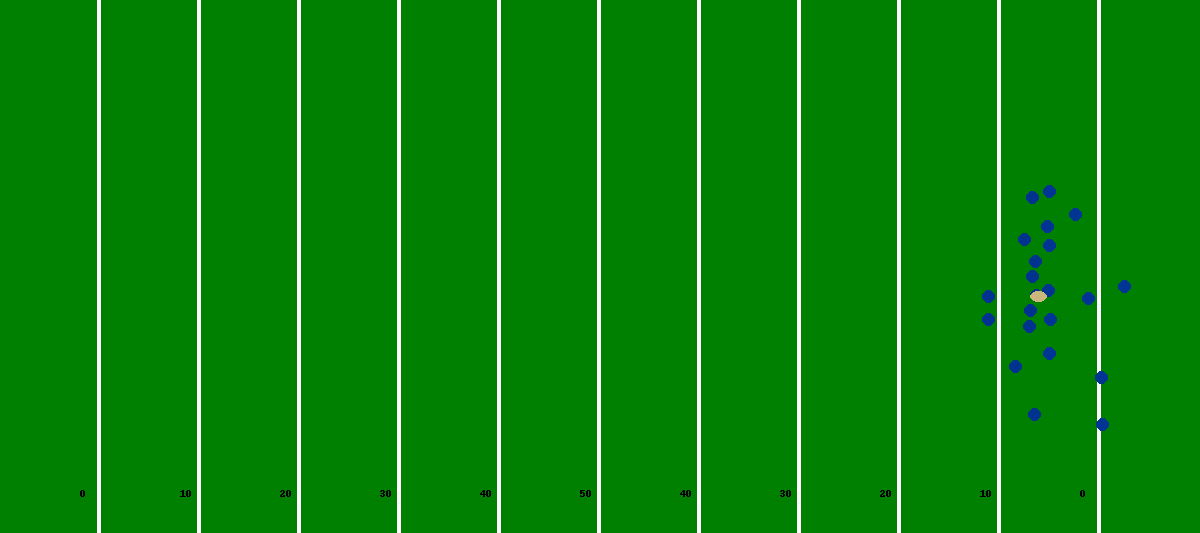

In [73]:
gameplay='20220908002712'


     
show_gif(create_play_gif(df_tracking[df_tracking['gameplayid']==gameplay], str(gameplay)+'.gif'))




# Data Dictionary
## Tackles data
- **gameId:** Game identifier, unique (numeric)
- **playId:** Play identifier, not unique across games (numeric)
- **nflId:** Player identification number, unique across players (numeric)
- **tackle:** Indicator for whether the given player made a tackle on the play (binary)
- **assist:** Indicator for whether the given player made an assist tackle on the play (binary)
- **forcedFumble:** Indicator for whether the given player forced a fumble on the play (binary)
- **pff_missedTackle:** Provided by Pro Football Focus (PFF). Indicator for whether the given player missed a tackle on the play (binary)

## Tracking data

- **gameId:** Game identifier, unique (numeric)
- **playId:** Play identifier, not unique across games (numeric)
- **nflId:** Player identification number, unique across players. When value is NA, row corresponds to ball. (numeric)
- **displayName:** Player name (text)
- **frameId:** Frame identifier for each play, starting at 1 (numeric)
- **time:** Time stamp of play (time, yyyy-mm-dd, hh:mm:ss)
- **jerseyNumber:** Jersey number of player (numeric)
- **club:** Team abbrevation of corresponding player (text)
- **playDirection:** Direction that the offense is moving (left or right)
- **x:** Player position along the long axis of the field, 0 - 120 yards. See Figure 1 below. (numeric)
- **y:** Player position along the short axis of the field, 0 - 53.3 yards. See Figure 1 below. (numeric)
- **s:** Speed in yards/second (numeric)
- **a:** Speed in yards/second^2 (numeric)
- **dis:** Distance traveled from prior time point, in yards (numeric)
- **o:** Player orientation (deg), 0 - 360 degrees (numeric)
- **dir:** Angle of player motion (deg), 0 - 360 degrees (numeric)
- **event:** Tagged play details, including moment of ball snap, pass release, pass catch, tackle, etc (text)

# Resources Used


- https://francis-press.com/uploads/papers/ndkLZY5nQLH6nilaE0nfMi0dxkAogA90wpqUB2vK.pdf
- https://digitalcommons.unl.edu/cgi/viewcontent.cgi?article=1079&context=cbbbpapers
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9459770/
- https://www.frontiersin.org/articles/10.3389/fspor.2021.669845/full
- https://entertainment.howstuffworks.com/physics-of-football.htm
- I used this notebook to standardize all of my directional data: 
https://www.kaggle.com/code/colinlagator/make-all-plays-left-right 